In [ ]:
# Names: Danika Mariam (1004014880), Chloe Li(1010033321), Rosa Lee (1005089761)
# Class: INF1340 LEC0101
# Final Project
# Date: Dec 9, 2023


# PREDICTIVE ANALYTICS

# import the drive
from google.colab import drive, files
drive.mount("/drive", force_remount=True)

# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split, learning_curve, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

songs = pd.read_csv('/drive/MyDrive/taylor_swift_spotify.csv')
output_file = open("output_predictive.txt", "w")
output_plots = PdfPages("plots_predictive.pdf")

Mounted at /drive


In [ ]:
# Linear Regression

def lin_regression():
  # Selecting features and target variable
  features = songs[['acousticness', 'danceability', 'energy', 'instrumentalness',
                  'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms']]
  target = songs['popularity']

  # Scaling features
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(features)

  # Splitting the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

  # Creating and training the linear regression model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Making predictions on the test set
  predictions = model.predict(X_test)
  mse = mean_squared_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  # calculating line of best fit
  a, b = np.polyfit(y_test, predictions, 1)
  plt.plot(y_test, a*y_test + b, color='red', label='Best Fit Line')

  # Plotting the observed vs predicted values for visual comparison
  plt.scatter(y_test, predictions)
  plt.xlabel('Observed')
  plt.ylabel('Predicted')
  plt.title('Observed vs Predicted Popularity')
  plt.savefig(output_plots, format='pdf')
  plt.show()

  print('Mean Squared Error:', mse)
  print('R^2 Score:', r2)
  output_file.write('Mean Squared Error:'+ str(mse) + "\n")
  output_file.write('R^2 Score:'+ str(r2) + "\n")

In [ ]:
# Logistic Regression

def log_regression():
  global features
  features = songs[['acousticness', 'danceability', 'energy', 'instrumentalness',
                  'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms']]
  target = songs['popularity']
  target = (target > target.median()).astype(int)

  scaler = StandardScaler()
  kfold = KFold(n_splits=10, random_state=42, shuffle=True)

  # Initialize the best model and parameters
  global model
  best_model = None
  best_params = {}
  best_accuracy = 0
  best_std = 0

  global X_train, X_test, y_train, y_test
  X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
  global X_train_scaled, X_test_scaled
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)



  for C in [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]:
      for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag']:
          # Set up the model with the current set of parameters
          model = LogisticRegression(C=C, solver=solver, max_iter=10000)

          # List to store accuracy for each fold
          accuracy = []

          # Perform K-Fold cross-validation
          for train_idx, test_idx in kfold.split(features):
              # Split the data
              X_train, X_test = features.values[train_idx], features.values[test_idx]
              y_train, y_test = target.values[train_idx], target.values[test_idx]

              # Scale the features
              X_train = scaler.fit_transform(X_train)
              X_test = scaler.transform(X_test)

              # Train the model
              model.fit(X_train, y_train)

              # Calculate accuracy
              score = model.score(X_test, y_test)
              accuracy.append(score)

          # Calculate the average accuracy and standard deviation
          avg_accuracy = np.mean(accuracy)
          std_accuracy = np.std(accuracy)

          # Update the best model if the current model is better
          if avg_accuracy > best_accuracy:
              best_model = model
              best_params = {'C': C, 'solver': solver}
              best_accuracy = avg_accuracy
              best_std = std_accuracy

  print("Best Model Parameters:", best_params)
  print("Best Cross-Validation Accuracy: "+ str(round(best_accuracy,2) * 100) + "%")
  print("Standard Deviation of CV Accuracy: "+ str(round(best_std,2) * 100)+ "%")

def coeff():
  coefficients = model.coef_[0]
  # Get feature names
  feature_names = features.columns

  # Create a DataFrame to display coefficients and feature importance
  coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

  # print coefficients
  print("Coefficients:")
  output_file.write("\n Coefficients: \n")
  print(coefficients_df)
  output_file.write(str(coefficients_df))

  # print 'feature_importance'
  print("\nFeature Importance:")
  output_file.write("\n Feature Importance: \n")
  print(coefficients_df[['Feature', 'Coefficient']].sort_values(by='Coefficient', key=abs, ascending=False))
  output_file.write(str(coefficients_df[['Feature', 'Coefficient']].sort_values(by='Coefficient', key=abs, ascending=False)))

In [ ]:
# Plot
def log_plot():
  y_probs = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

  # Plotting the predicted probabilities against the actual values
  plt.figure(figsize=(10, 6))
  plt.scatter(range(len(y_test)), y_probs, c='r', label='Actual')
  plt.scatter(range(len(y_test)), y_test, alpha=0.5, edgecolor='k', label='Predicted')
  plt.title('Predicted Probabilities and Actual Values')
  plt.xlabel('Samples')
  plt.ylabel('Probability')
  plt.legend()
  plt.savefig(output_plots, format='pdf')
  plt.show()

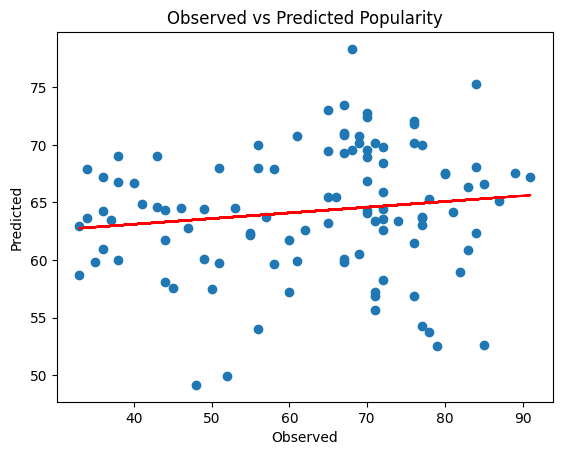

Mean Squared Error: 244.12007320828295
R^2 Score: -0.035057783355679106
Best Model Parameters: {'C': 0.05, 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 57.99999999999999%
Standard Deviation of CV Accuracy: 7.000000000000001%
Coefficients:
            Feature  Coefficient
0      acousticness    -0.262386
1      danceability     0.139565
2            energy     0.352111
3  instrumentalness    -0.071598
4          liveness    -0.482586
5          loudness    -0.666927
6       speechiness     0.083554
7             tempo    -0.061953
8           valence    -0.211628
9       duration_ms    -0.185918

Feature Importance:
            Feature  Coefficient
5          loudness    -0.666927
4          liveness    -0.482586
2            energy     0.352111
0      acousticness    -0.262386
8           valence    -0.211628
9       duration_ms    -0.185918
1      danceability     0.139565
6       speechiness     0.083554
3  instrumentalness    -0.071598
7             tempo    -0.061953


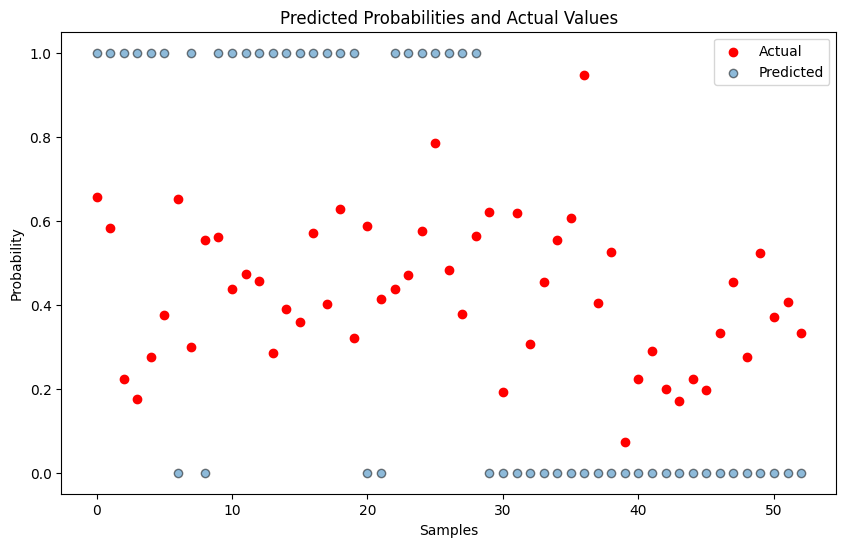

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def main():
  lin_regression()
  log_regression()
  coeff()
  log_plot()
  output_file.close()
  output_plots.close()

main()
files.download('output_predictive.txt')
files.download('plots_predictive.pdf')